# KC characterization

## Introduction

This file is created in order to study main parameters of K-Complexes (KC), following this structure:

<img src="KC_points_detection.jpg" alt="" width="600"/>


Where each one is:
- <font color="red">Start of KC</font>
- <font color="green">Second Maximum of KC</font>
- <font color="yellow">Minimum of KC</font>
- ✖ = <font color="white">Middle of KC</font>
- <font color="blue">Maximum of KC</font>
- <font color="black">End of KC</font>

You can see a real KC labeled here with this points detected:

<img src="example_real_KC.png" alt="" width="800"/>

The way each point is found by the algorithm created follows the next logic:

1. First the main observable points are detected: <font color="yellow">minimum</font> and <font color="blue">maximum </font>

<img src="KC_points_detection_explanation_0.jpg" alt="" width="500"/>

These points are the ones used by the localizator to detect a raw candidate of KC, so that's why they are the main reference of each event. 

2. These points will define the <font color="white">middle of KC</font> (✖), as the center sample between these two events.

<img src="KC_points_detection_explanation_1.jpg" alt="" width="500"/>

This center is the one that will be used to get the "zone of interest" (ZOI) for this study. This window is the same length for both sides of the center (1.5 seconds per side, so 3 seconds in total). This ZOI is the one that was used to study the characteristics of the KC.

3. So now there are two zones to find the other points of KC: <font color="magenta">before</font> the <font color="yellow">minimum of KC</font> and <font color="green">after</font> the <font color="blue">maximum of KC</font> inside this ZOI.

<img src="KC_points_detection_explanation_2.jpg" alt="" width="500"/>

4. <font color="green">After</font> the <font color="blue">maximum of KC</font>, the **end of KC** is going to be defined as the first zero-crossing downstate found in this <font color="green">region</font>. If no zero-crossing is found, it was going to be study where the experts put the end of the label in order to use this value as default for this case.

> _Downstate_ means that the zero-crossing is from positive to negative direction

<img src="KC_points_detection_explanation_3.jpg" alt="" width="500"/>

5. <font color="magenta">Before</font> the <font color="yellow">minimum of KC</font>, the first event to find is the <font color="green">second maximum of KC</font>. This event is going to be defined as the maximum point **<font color="purple">before</font>** the <font color="yellow">minimum</font> inside an **<font color="purple">interval</font>**. The length of the **<font color="purple">interval</font>** is going to be study depending on what experts has labeled.

<img src="KC_points_detection_explanation_4.jpg" alt="" width="500"/>

6. <font color="orange">Before</font> the <font color="green">second maximum</font>, the last point to detect is the <font color="green">start of KC</font>. It is going to be defined as the last zero-crossing upstate found in this <font color="orange">region</font> (defined depending on <font color="green">second maximum</font> and <font color="magenta">region before the </font> <font color="yellow">minimum</font>). If no zero-crossing is found, it was going to be study where the experts put the start of the label in order to use this value as default for this case.

> _Upstate_ means that the zero-crossing is from negative to positive direction

<img src="KC_points_detection_explanation_5.jpg" alt="" width="500"/>

**In resume:**

There are 3 intervals to study how the KC is characterized according to experts that labeled these events

- <font color="orange">where to define the start of the KC</font>
- <font color="magenta">Where to define the second maximum of the KC</font>
- <font color="green">Where to define the end of the KC</font>

And all of these events are going to be defined depending on the <font color="white">middle of KC</font> (✖)

<img src="KC_points_detection_explanation_6.jpg" alt="" width="500"/>

---

## Analysis

Starting importing libraries and usefull functions in this repo:

In [3]:
import os
os.chdir(r'/home/lsym/Aylin/PhD/KC_detection_algorithm')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mne
import re
import seaborn as sns
import src.utils.localizator_utils as loc

In [4]:
SUBJECTS = ['ExpS11', 'ExpS12', 'ExpS17', 'ExpS21', 'ExpS28', 'ExpS36', 'ExpS37', 'ExpS40', 'ExpS43', 'ExpS45', 'ExpS66']
sfreq = 200

In [5]:
def get_onset_duration(annotations, sfreq):
    regex_KC = r"^KC(?:_\w+)?$"
    for ann in annotations:
        onsets = [int(ann['onset']*sfreq) for ann in annotations if re.match(regex_KC, ann['description'])]
        durations = [float(ann['duration']) for ann in annotations if re.match(regex_KC, ann['description'])]
    return onsets, durations

In [8]:
path_to_npys = os.path.join('reports','npy','characterization')
path_to_annotations=os.path.join('data','annotations')

KCs = np.array(np.empty((0, 600)))
onsets = []
durations = []
starts_zoi = []
for subj in SUBJECTS:
    # Get KC
    KCs_in_zoi = np.load(os.path.join(path_to_npys, subj+'_KC_timelocked2center.npy'))
    KCs = np.vstack((KCs, KCs_in_zoi))

    # Get annotations
    annots = mne.read_annotations(os.path.join(path_to_annotations, subj+'_annotations.txt'), sfreq=sfreq)
    o, d = get_onset_duration(annots, sfreq)
    onsets += o
    durations += d

    # Get new_starts_of_zoi
    new_start_of_zoi = np.load(os.path.join(path_to_npys, subj+'_new_starts_timelocked2center.npy'))
    starts_zoi += new_start_of_zoi.tolist()

/home/lsym/.venvs/kc_detect_venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/lsym/.venvs/kc_detect_venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/lsym/.venvs/kc_detect_venv/lib/python3.9/site-packages/scipy/signal/_filter_design.py:2759: RuntimeWarning: invalid value encountered in scalar divide
  k_z = k * real(prod(fs2 - z) / prod(fs2 - p))


FileNotFoundError: [Errno 2] No such file or directory: '/home/lsym/Aylin/PhD/KC_detection_algorithm/reports/figures/KCs_characterization/KC1.png'

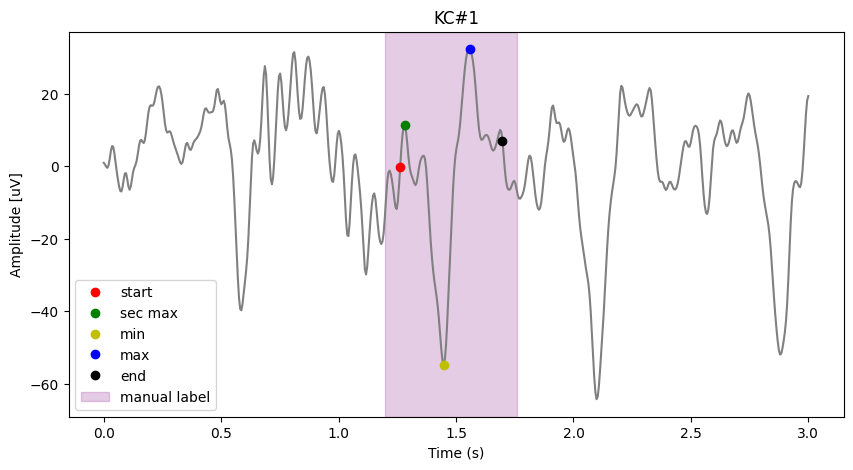

In [9]:
t = np.linspace(0, 3, sfreq*3)
for i, kc in enumerate(KCs):
    idx_start_label_in_zoi, idx_start_in_zoi, idx_sec_maximum_in_zoi, idx_minimum_in_zoi, idx_maximum_in_zoi, idx_end_label_in_zoi, idx_end_in_zoi, num_of_zc_until_minimum, num_of_zc_until_sec_maximum, num_of_zc_after_minimum, num_of_zc_after_maximum = loc.detect_points_of_KC(kc, starts_zoi[i], onsets[i], durations[i], sfreq)
    kc = np.array(kc) - np.mean(kc)
    kc = kc*1e6
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(t, kc, 'gray')
    ax.plot(t[idx_start_in_zoi], kc[idx_start_in_zoi], 'ro', label='start')
    ax.plot(t[idx_sec_maximum_in_zoi], kc[idx_sec_maximum_in_zoi], 'go', label='sec max')
    ax.plot(t[idx_minimum_in_zoi], kc[idx_minimum_in_zoi], 'yo', label='min')
    ax.plot(t[idx_maximum_in_zoi], kc[idx_maximum_in_zoi], 'bo', label='max')
    ax.plot(t[idx_end_in_zoi], kc[idx_end_in_zoi], 'ko', label='end')
    ax.axvspan(t[idx_start_label_in_zoi], t[idx_end_label_in_zoi], color='purple', alpha=0.2, label='manual label')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude [uV]')
    ax.legend()
    plt.title('KC#'+str(i+1))
    plt.savefig(os.path.join('reports','figures','KCs_characterization','KC'+str(i+1)+'.png'))
    plt.close()

In [11]:
cols = ['dif_start_label','onset_2_secmax', 'onset_2_min', 'secmax_2_min', 'min_2_end', 'min', 'end_def', 'end_label',
        'max_2_end', 'secmax',
        'num_of_zc_until_sec_maximum',
        'num_of_zc_after_minimum', 
        'num_of_zc_after_maximum']

df = pd.DataFrame(columns=cols)
for i, kc in enumerate(KCs):
        idx_start_label_in_zoi, idx_start_in_zoi, idx_sec_maximum_in_zoi, idx_minimum_in_zoi, idx_maximum_in_zoi, idx_end_label_in_zoi, idx_end_in_zoi, num_of_zc_until_minimum, num_of_zc_until_sec_maximum, num_of_zc_after_minimum, num_of_zc_after_maximum = loc.detect_points_of_KC(kc, starts_zoi[i], onsets[i], durations[i], sfreq)
        dif_start_label = idx_start_in_zoi - idx_start_label_in_zoi
        secmax_2_min = idx_minimum_in_zoi - idx_sec_maximum_in_zoi
        min_2_end = idx_end_in_zoi - idx_minimum_in_zoi
        max_2_end = idx_end_in_zoi - idx_maximum_in_zoi
        onset_2_secmax = idx_sec_maximum_in_zoi - idx_start_label_in_zoi
        onset_2_min = idx_minimum_in_zoi - idx_start_label_in_zoi

        data = [dif_start_label, onset_2_secmax, onset_2_min, secmax_2_min, min_2_end, idx_minimum_in_zoi, idx_end_in_zoi, idx_end_label_in_zoi,
                max_2_end, idx_sec_maximum_in_zoi]
        data = [round(d/sfreq, 3) for d in data]
        data += [num_of_zc_until_sec_maximum, num_of_zc_after_minimum, num_of_zc_after_maximum]
        df.loc[len(df)] = pd.Series(data, index=df.columns)

/home/lsym/.venvs/kc_detect_venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/lsym/.venvs/kc_detect_venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/lsym/.venvs/kc_detect_venv/lib/python3.9/site-packages/scipy/signal/_filter_design.py:2759: RuntimeWarning: invalid value encountered in scalar divide
  k_z = k * real(prod(fs2 - z) / prod(fs2 - p))
/home/lsym/.venvs/kc_detect_venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/lsym/.venvs/kc_detect_venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passk

In [12]:
df.head(6)

,dif_start_label,onset_2_secmax,onset_2_min,secmax_2_min,min_2_end,min,end_def,end_label,max_2_end,secmax,num_of_zc_until_sec_maximum,num_of_zc_after_minimum,num_of_zc_after_maximum
0,0.065,0.085,0.250,0.165,0.250,1.445,1.695,1.755,0.140,1.280,1.0,1.0,0.0
1,0.000,0.075,0.245,0.170,0.365,1.375,1.740,1.745,0.115,1.205,0.0,1.0,0.0
2,0.005,0.100,0.375,0.275,0.390,1.450,1.840,1.845,0.290,1.175,1.0,1.0,0.0
3,0.070,0.105,0.220,0.115,0.300,1.430,1.730,1.735,0.155,1.315,2.0,2.0,1.0
4,0.000,0.065,0.455,0.390,0.300,1.440,1.740,1.880,0.180,1.050,0.0,1.0,0.0
5,0.015,0.065,0.160,0.095,0.515,1.290,1.805,1.865,0.095,1.195,1.0,1.0,0.0


In [13]:
df.describe()

,dif_start_label,onset_2_secmax,onset_2_min,secmax_2_min,min_2_end,min,end_def,end_label,max_2_end,secmax,num_of_zc_until_sec_maximum,num_of_zc_after_minimum,num_of_zc_after_maximum
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,0.025464,0.083907,0.333005,0.249098,0.673934,1.293607,1.967541,2.001284,0.258634,1.044508,0.726776,1.218579,0.180328
std,0.037886,0.064987,0.139216,0.128726,0.256776,0.091034,0.193814,0.184581,0.160542,0.176274,0.735067,0.708104,0.413037
min,0.000000,0.000000,0.085000,0.055000,0.190000,1.050000,1.630000,1.655000,0.010000,0.545000,0.000000,0.000000,0.000000
25%,0.000000,0.035000,0.237500,0.150000,0.470000,1.225000,1.815000,1.852500,0.140000,0.937500,0.000000,1.000000,0.000000
50%,0.000000,0.075000,0.300000,0.210000,0.680000,1.295000,1.955000,1.985000,0.225000,1.055000,1.000000,1.000000,0.000000
75%,0.045000,0.115000,0.415000,0.315000,0.862500,1.360000,2.090000,2.110000,0.350000,1.175000,1.000000,2.000000,0.000000
max,0.185000,0.490000,0.795000,0.705000,1.320000,1.455000,2.515000,2.560000,0.795000,1.365000,4.000000,4.000000,2.000000


## Conclusion

These 3 intervals could be defined as

- <font color="orange">Where to define the start of the KC</font> is on average $0.1$ seconds before the second maximum or $0.33 \pm 0.13$ seconds before the minimum.
- <font color="magenta">Where to define the second maximum of the KC</font> is on average $0.25 \pm 0.13$ seconds before the minimum.
- <font color="green">Where to define the end of the KC</font> is on average $0.26 \pm 0.16$ seconds after the maximum.

<img src="KC_points_detection_explanation_6.jpg" alt="" width="500"/>

What was intended to be studied on zero-crossings parameters was to know how probably is to find a zero crossing to define start or end of KC. 

What is concluded is that it is more common to detect the initial zero-crossing (upstate) at the starting point of KC than the zero-crossing (downstate) at the ending point of KC.

All of these results are going to be taken into account for localizator algorithm as default values for each interval as:

- `interval_to_start = 0.1` (_seconds before the secmax_)
- `interval_to_secmax = 0.3` (_seconds before the minimum_)
- `interval_to_end = 0.3` (_seconds after the maximum_)